In [1]:
library(tidyverse)
library(arrow)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.0     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp




In [2]:

df_shinka <- as_tibble(read_parquet("shinka.parquet"))
df_shinka_scipy <- as_tibble(read_parquet("shinka_scipy.parquet"))
df_rayevolve <- as_tibble(read_parquet("rayevolve.parquet"))
df_rayevolve_scipy <- as_tibble(read_parquet("rayevolve_scipy.parquet"))

df_shinka <- df_shinka %>% filter(correct == TRUE)
df_shinka_scipy <- df_shinka_scipy %>% filter(correct == TRUE)

In [3]:
colnames(df_shinka)

[1] "id"                      "code"                   
 [3] "language"                "parent_id"              
 [5] "archive_inspiration_ids" "top_k_inspiration_ids"  
 [7] "generation"              "timestamp"              
 [9] "complexity"              "embedding"              
[11] "code_diff"               "correct"                
[13] "combined_score"          "compute_time"           
[15] "api_costs"               "embed_cost"             
[17] "novelty_cost"            "patch_type"             
[19] "patch_name"              "patch_description"      
[21] "stdout_log"              "stderr_log"             
[23] "code_analysis_metrics"   "centers_str"            
[25] "num_circles"             "reported_sum_of_radii"  
[27] "text_feedback"           "_is_island_copy"        
[29] "_original_program_id"    "num_applied"            
[31] "error_attempt"           "novelty_attempt"        
[33] "resample_attempt"        "patch_attempt"          
[35] "model_name"              "temperature"            
[37] "max_tokens"              "llm_result"             
[39] "diff_summary"

In [4]:
add_best_score <- function(df, gen_col = "generation", score_col = "combined_score", best_col = "best_score") {
  gen_sym   <- rlang::sym(gen_col)
  score_sym <- rlang::sym(score_col)
  best_sym  <- rlang::sym(best_col)

  # Sort by generation
  df_sorted <- dplyr::arrange(df, !!gen_sym)

  # Per-generation max, then cumulative best across generations
  gen_best <- df_sorted %>%
    dplyr::group_by(!!gen_sym) %>%
    dplyr::summarise(gen_max = max(!!score_sym, na.rm = TRUE), .groups = "drop") %>%
    dplyr::mutate(
      # Treat -Inf (all NA) as NA before cummax
      gen_max = dplyr::if_else(is.infinite(gen_max), NA_real_, gen_max),
      !!best_sym := cummax(dplyr::coalesce(gen_max, -Inf)),
      !!best_sym := dplyr::na_if(!!best_sym, -Inf)
    ) %>%
    dplyr::select(!!gen_sym, !!best_sym)

  # Attach best_score to all rows for that generation
  df_sorted %>% dplyr::left_join(gen_best, by = gen_col)
}

# Example usage:
df_shinka <- add_best_score(df_shinka)
df_shinka_scipy <- add_best_score(df_shinka_scipy)
df_rayevolve <- add_best_score(df_rayevolve)
df_rayevolve_scipy <- add_best_score(df_rayevolve_scipy)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


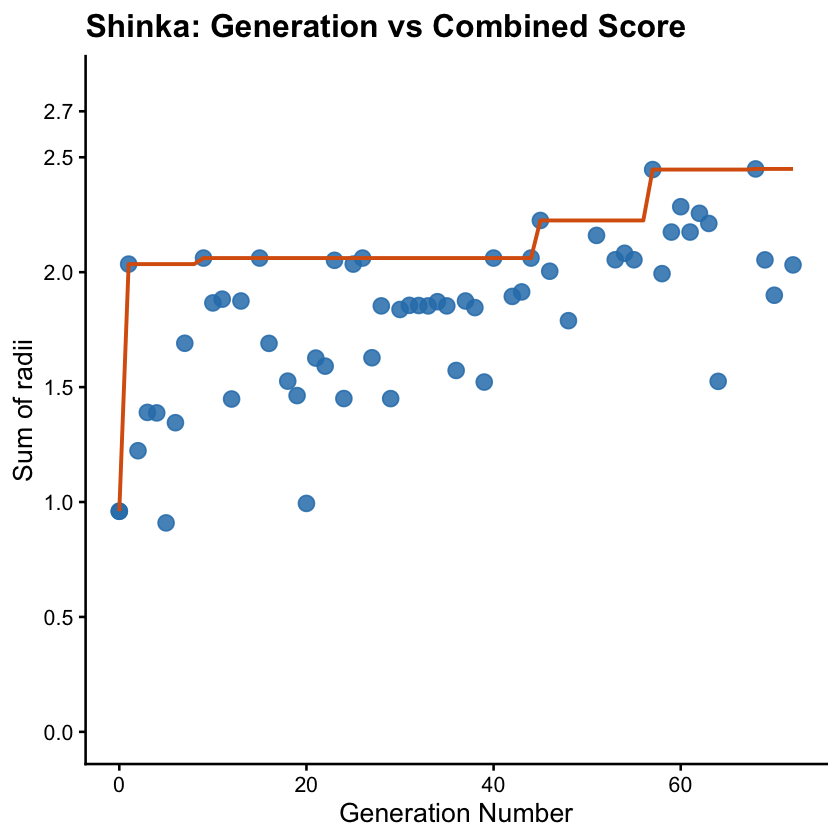

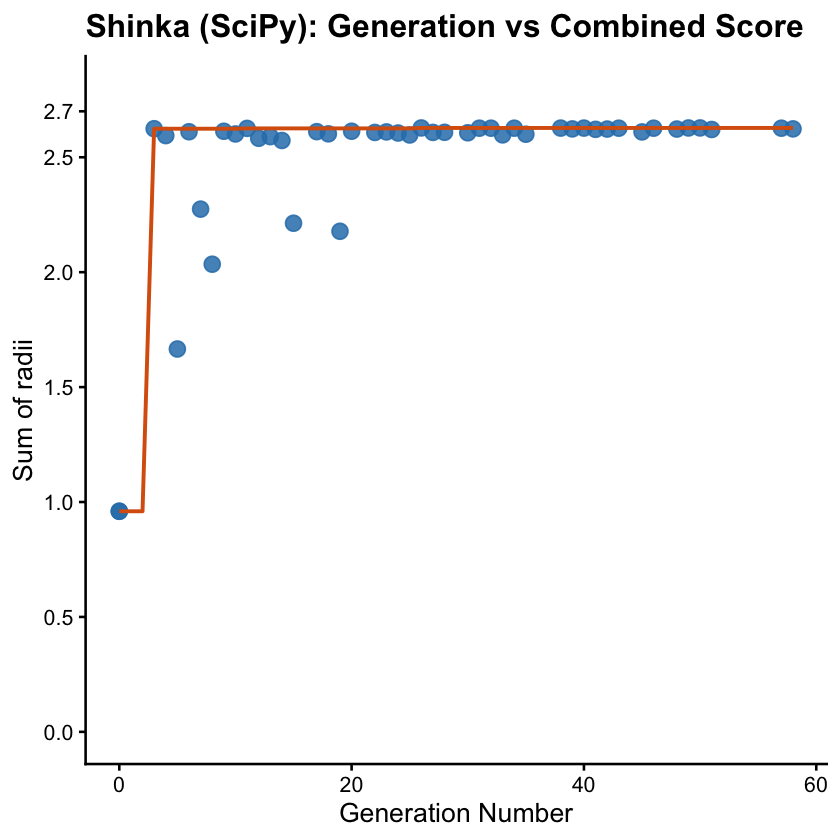

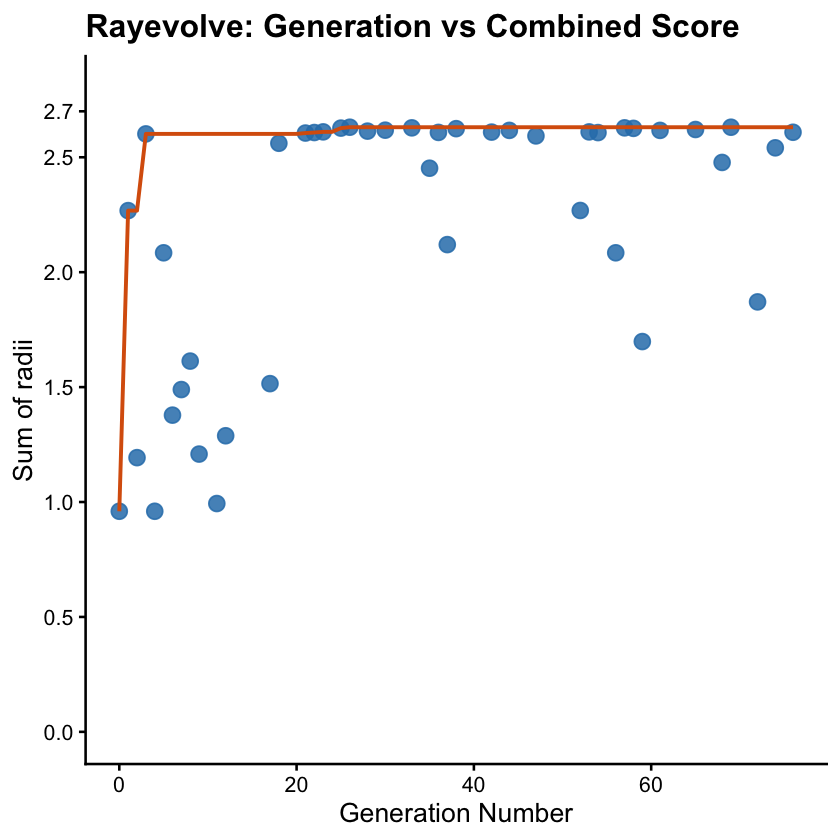

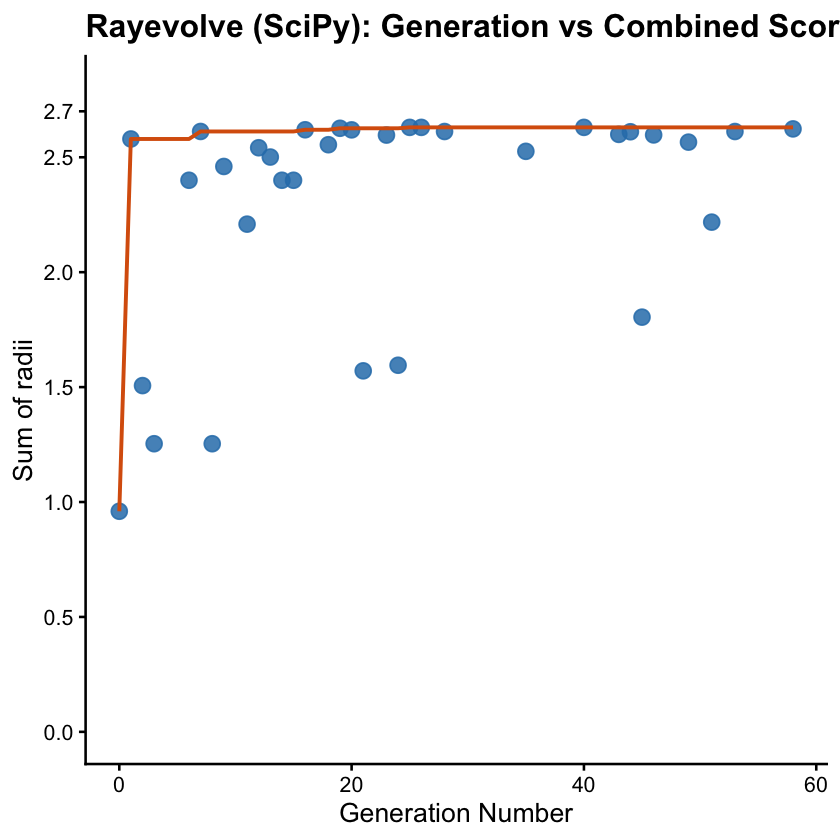

In [5]:

# Reusable plot function
plot_gen_vs_score <- function(df,
                              title = "Generation vs Combined Score",
                              gen_col = "generation",
                              score_col = "combined_score",
                              best_col = "best_score",
                              y_lim = c(0, 2.8),
                              point_size = 4.0,
                              line_size = 1.1,
                              base_size = 16,
                              y_breaks_n = 10) {

  gen_sym   <- rlang::sym(gen_col)
  score_sym <- rlang::sym(score_col)
  best_sym  <- rlang::sym(best_col)

  points_df <- df %>% dplyr::filter(!is.na(!!gen_sym), !is.na(!!score_sym))

  # Build cumulative-best line that extends to the last generation
  line_df <- df %>%
    dplyr::filter(!is.na(!!gen_sym)) %>%
    dplyr::distinct(!!gen_sym, !!best_sym) %>%
    dplyr::arrange(!!gen_sym)

  rng <- range(dplyr::pull(line_df, !!gen_sym), na.rm = TRUE)
  seq_df <- tibble::tibble(!!gen_sym := seq(rng[1], rng[2]))
  line_df <- seq_df %>%
    dplyr::left_join(line_df, by = gen_col) %>%
    tidyr::fill(!!best_sym, .direction = "down")

  p <- ggplot2::ggplot(points_df, ggplot2::aes(x = !!gen_sym, y = !!score_sym)) +
    ggplot2::geom_point(alpha = 0.85, color = "#2C7FB8", size = point_size) +
    ggplot2::geom_line(
      data = line_df,
      ggplot2::aes(x = !!gen_sym, y = !!best_sym),
      color = "#D95F0E",
      size = line_size
    ) +
    ggplot2::labs(
      title = title,
      x = "Generation Number",
      y = "Sum of radii"
    ) +
    ggplot2::theme_classic(base_size = base_size) +
    ggplot2::theme(
      axis.line  = ggplot2::element_line(color = "black"),
      axis.ticks = ggplot2::element_line(color = "black"),
      axis.text  = ggplot2::element_text(color = "black"),
      axis.title = ggplot2::element_text(color = "black"),
      plot.title = ggplot2::element_text(face = "bold")
    )

  # Add y-axis ticks density control and force a tick at 2.7
  y_breaks_fun <- function(lims) {
    sort(unique(c(scales::pretty_breaks(n = y_breaks_n)(lims), 2.7)))
  }
  if (is.null(y_lim)) {
    p <- p + ggplot2::scale_y_continuous(breaks = y_breaks_fun)
  } else {
    p <- p + ggplot2::scale_y_continuous(limits = range(c(y_lim, 2.7)), breaks = y_breaks_fun)
  }

  p
}

# Usage
plot_gen_vs_score(df_shinka,       title = "Shinka: Generation vs Combined Score")
plot_gen_vs_score(df_shinka_scipy, title = "Shinka (SciPy): Generation vs Combined Score")
plot_gen_vs_score(df_rayevolve,    title = "Rayevolve: Generation vs Combined Score")
plot_gen_vs_score(df_rayevolve_scipy,    title = "Rayevolve (SciPy): Generation vs Combined Score")
